<h2>Embedding Clustering Challenge</h2>


Nowadays Deep Neural Networks(DNN) are mainly used for solving end-to-end problems such as classification, detection or segmentation. 
<br>
In this challenge you will use a DNN to generate embeddings, we refer to an embedding as a vector representation of any size of your choice (19, 64, 128, 213, 256...) which represents an image. Thus two different images should have two different embeddings as well as similar images should have embeddings that are close by distance in the embedding space and vice versa.

The challenge consists on several sub tasks: 
<ol>
    <li> Design and create a simple network </li>
    <li> Analyze and prepare the provided data for training a model able to provide meaningful embeddings </li>
    <li> Use the generated embeddings to cluster products in a shelf image in order to generate aggregate product regions.</li>
</ol>
<br>

<br>
Let's go in the details of the structure of the challenge directory.

You can find the following files and directory:
<ul>
    <li> <b>dataset:</b> a directory containing a set of directories named by class label to use for training the network</li>
    <li> <b>shelf.jpg:</b> a shelf image containing the products we would like to cluster</li>
    <li> <b>detection.json:</b> a json file containing the coordinates for each crop product inside the shelf image plus its ID</li>
</ul>
<br>
In the following cells of the notebook you can find further information about what we are expecting from you. Feel free to enrich the cells with your thoughs and comments.
<br>

In addition we would like to evaluate also your ability to produce well structured code, so please wrap up all the Notebook content into a structured python project.

<br>
We estimated that the challenge can take around 6 hours to be executed, try to record the time used for the test and report it during the submission. In case you are exceeding substantially the time limit and you cannot afford to invest more time we suggest you to skip the bonus steps but still produce a structured python project.
<br>


Submission expected output:  Compressed directory containing this Notebook with attached the relevant plots and output images + a python project folder with the organised code.


GOOD LUCK!!




<h3>Network Building</h3>
<p> Develop a very simple Neural Network model using the framework you feel more confortable among Pytorch(preferable) or Tensorflow.<br> 
    The objective of the network during inference time is to generate embedding of a given image.
</p>

In [1]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, n_cls, embedding_dim=64):
        super().__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 4, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
                                      nn.Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False))
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.embedding = nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=576, out_features=embedding_dim, bias=True),
                                       nn.Sigmoid(),
                                       nn.LayerNorm(embedding_dim))

        anchors = torch.rand(1, n_cls, embedding_dim, requires_grad=True) - 0.5
        self.anchors = nn.Parameter(anchors, requires_grad=True)
        self.similarity = nn.CosineSimilarity(dim=2)

    def get_features(self, x):
        x = self.features(x)
        return x

    def get_embedding(self, x):
        x = self.get_features(x)
        x = self.pool(x)
        mbd = self.embedding(x)

        return mbd

    def get_similarity(self, mbd):
        sim = self.similarity(mbd[:, None, :], self.anchors)
        return sim

    def forward(self, x, lmd=3.0):
        mbd = self.get_embedding(x)
        sim = self.get_similarity(mbd)
        return sim * lmd

<h3>Training and Data Analysis</h3>


In [2]:
from copy import deepcopy
import numpy as np
from torch import optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import os.path as osp

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':
                model.train()
            else:
                model.eval()

            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                # print()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = 1.0 * running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = deepcopy(model.state_dict())
            else:
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    history = np.vstack((train_loss_history, train_acc_history, val_loss_history, val_acc_history))

    return best_model_wts, history


# training
t = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
batch_size = 100
embedding_dim = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root = osp.join('dataset')
dataset = ImageFolder(root, t)
num_classes = len(dataset.classes)

# train-val split & data loaders
train_set, val_set = random_split(dataset, (0.8, 0.2))
dataloaders = dict()
dataloaders['train'] = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# model
model = Network(num_classes, embedding_dim)
model.to(device)

# criterion
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_wts, history = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20)

# reload the best weights
model.load_state_dict(best_model_wts)

Epoch 0/19
----------
train Loss: 1.8817 Acc: 0.6571
val Loss: 1.2652 Acc: 0.9284

Epoch 1/19
----------
train Loss: 1.1247 Acc: 0.9384
val Loss: 1.0325 Acc: 0.9478

Epoch 2/19
----------
train Loss: 0.9822 Acc: 0.9541
val Loss: 0.9535 Acc: 0.9568

Epoch 3/19
----------
train Loss: 0.9184 Acc: 0.9579
val Loss: 0.8990 Acc: 0.9583

Epoch 4/19
----------
train Loss: 0.8788 Acc: 0.9602
val Loss: 0.8757 Acc: 0.9578

Epoch 5/19
----------
train Loss: 0.8561 Acc: 0.9643
val Loss: 0.8555 Acc: 0.9597

Epoch 6/19
----------
train Loss: 0.8408 Acc: 0.9658
val Loss: 0.8453 Acc: 0.9616

Epoch 7/19
----------
train Loss: 0.8282 Acc: 0.9662
val Loss: 0.8382 Acc: 0.9611

Epoch 8/19
----------
train Loss: 0.8202 Acc: 0.9650
val Loss: 0.8304 Acc: 0.9616

Epoch 9/19
----------
train Loss: 0.8148 Acc: 0.9669
val Loss: 0.8255 Acc: 0.9620

Epoch 10/19
----------
train Loss: 0.8090 Acc: 0.9660
val Loss: 0.8232 Acc: 0.9630

Epoch 11/19
----------
train Loss: 0.8043 Acc: 0.9661
val Loss: 0.8166 Acc: 0.9635

Ep

<All keys matched successfully>

<h3>Bonus Analysis</h3>
<ul>
    <li> Show us the learning cruves: loss train/val, choosen metric(s) train/val.</li>
    <li> Show us the confusion matrix after the training. ATTENTION: this analysis is moved later in the embedding analysis section to share computation results.</li>
    <li> Show three images and respective feature maps side to side. To generate the feature map take the output of the conv2D (H x W x K) with the smallest H and W, then average over the depth and upscale it to the image size that you choose for your training.</li>
</ul>

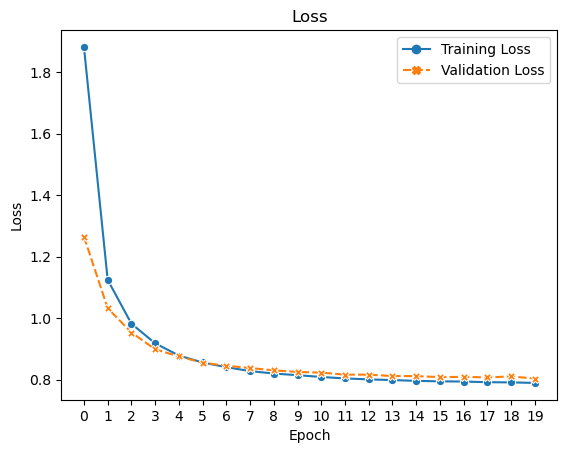

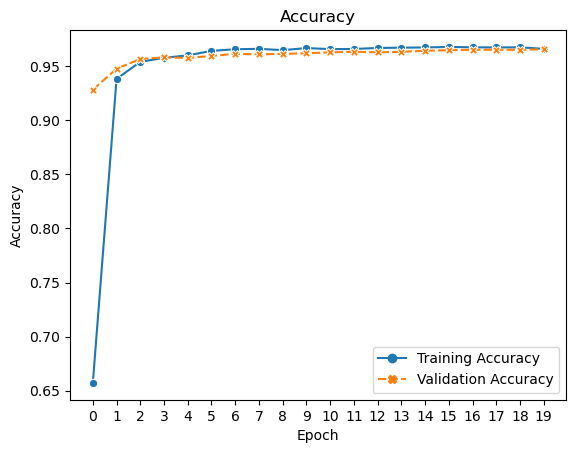

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Confusion matrix and embeddings share the same inference result. Thus, this analysis will be done later along with embeddings.


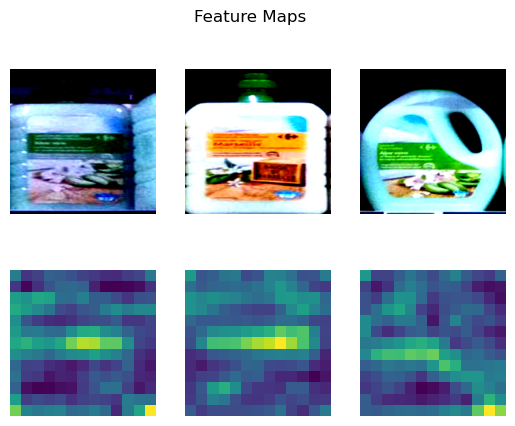

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import pandas as pd


# training history
def plot_history(history):
    plt.ion()

    num_epoch = np.shape(history)[1]

    df = pd.DataFrame()
    epochs = np.arange(num_epoch, dtype=int)
    df["Training Loss"] = history[0, :]
    df["Validation Loss"] = history[2, :]
    df["Training Accuracy"] = history[1, :]
    df["Validation Accuracy"] = history[3, :]

    plt.figure()
    g = sns.lineplot(data=df[['Training Loss', 'Validation Loss']], markers=True)
    g.set(title='Loss', xlabel='Epoch', ylabel='Loss', xticks=epochs)
    plt.show()

    plt.figure()
    g = sns.lineplot(data=df[['Training Accuracy', 'Validation Accuracy']], markers=True)
    g.set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy', xticks=epochs)
    plt.show()

plot_history(history)


# confusion matrix
print("Confusion matrix and embeddings share the same inference result. Thus, this analysis will be done later along with embeddings.")


# feature maps
def get_features(model, samples, device):
    model.eval()
    features = model.get_features(samples.to(device))

    return features.detach().cpu().numpy()

def plot_feature_maps(ims, features):
    plt.ion()

    assert len(ims) == len(features)
    g, axes = plt.subplots(2, len(ims))
    g.suptitle('Feature Maps')
    for i, (im, feat) in enumerate(zip(ims, features)):
        feat = np.mean(feat, axis=0, keepdims=False)

        axes[0, i].imshow(np.transpose(im, (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(feat)
        axes[1, i].axis('off')
    plt.show()

n_sample = 3
np.random.seed(42*n_sample)
sample_idx = np.random.choice(len(dataset), n_sample, replace=False)
sample_dataset = Subset(dataset, sample_idx)
dataloader_sample = DataLoader(sample_dataset, batch_size=n_sample, shuffle=False)
samples, _ = next(iter(dataloader_sample))
features = get_features(model, samples, device)
plot_feature_maps(samples.numpy(), features)

<h3>Embedding Computation (+ Confusion Matrix)</h3>

In [4]:
# embeddings
def infer(model, dataloader, device, embedding_dim, testing=True):
    model.eval()
    embeddings = np.empty((0, embedding_dim))
    targets = []
    predictions = []
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs = model.get_embedding(inputs)
        norm = torch.norm(outputs, dim=1, keepdim=True)
        vectors = outputs / norm

        embeddings = np.vstack((embeddings, vectors.detach().cpu().numpy()))
        targets += list(labels.detach().cpu().numpy())

        if not testing:
            outputs = model.get_similarity(outputs)
            _, preds = torch.max(outputs, 1)
            predictions += list(preds.detach().cpu().numpy())

    if testing:
        return embeddings, targets
    else:
        return embeddings, targets, predictions
    
dataloader_train = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # entire training set
embeddings, labels, predictions = infer(model, dataloader_train, device, embedding_dim, testing=False)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# confusion matrix
mat = confusion_matrix(y_true=labels, y_pred=predictions)

df_mat = pd.DataFrame(mat)
df_mat.columns = pd.MultiIndex.from_product((('Prediction', ), [idx_to_class[c] for c in df_mat.columns]))
df_mat.index = pd.MultiIndex.from_product((('Ground Truths', ), [idx_to_class[c] for c in df_mat.index]))  

df_mat.style


<h3>Bonus Embedding Visualisation</h3>
<p> Probably the embedding generated are vectors containg many dimensions can you visualise them in a 2(3) dimensional space?<p>

KL divergence: 1.1032601594924927


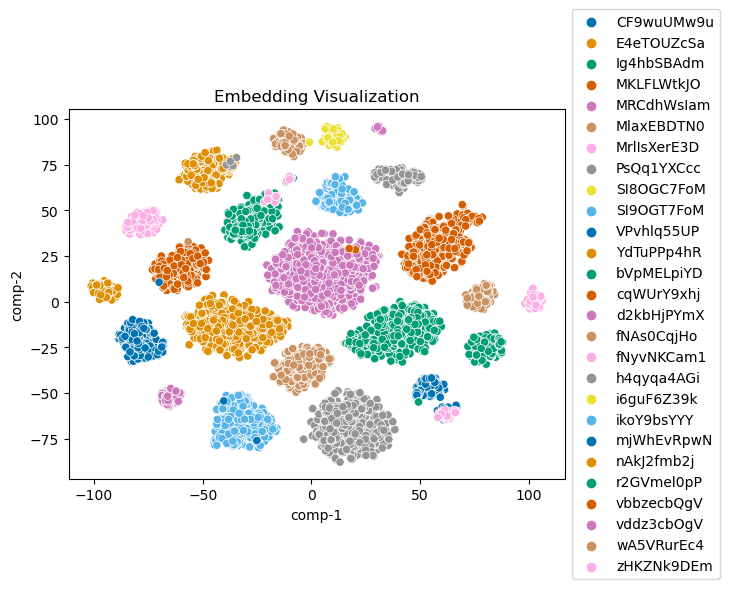

In [5]:
# embedding visualization (T-SNE)
def cosine_distance(embeddings):
    sim = np.matmul(embeddings, np.transpose(embeddings))
    dist = np.maximum(1.0 - sim, 0.0)
    return dist

def plot_embeddings(embeddings, cls):
    plt.ion()

    # cosine similarity
    dist = cosine_distance(embeddings)

    tsne = TSNE(n_components=2, init='random', metric='precomputed')
    embeddings_tsne = tsne.fit_transform(dist)
    print("KL divergence: " + str(tsne.kl_divergence_))

    df = pd.DataFrame()
    df["y"] = cls
    df["comp-1"] = embeddings_tsne[:, 0]
    df["comp-2"] = embeddings_tsne[:, 1]

    num_cls = len(np.unique(cls))
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("colorblind", num_cls),
                    data=df).set(title="Embedding Visualization")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
cls = [idx_to_class[lb] for lb in labels]
plot_embeddings(embeddings, cls)

<h3>Clustering</h3>
<p> Generate shelf regions composed by same products in the shelf image<p>

In [10]:
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, OPTICS
from PIL import Image
from torch.utils.data import Dataset
import json

def clustering(embeddings):
    # cosine similarity
    dist = cosine_distance(embeddings)

    # first clustering
    clusters = HDBSCAN(min_cluster_size=2, metric='precomputed').fit_predict(dist)

    # second clustering of noises
    noises = clusters == -1
    embeddings_noises = embeddings[noises, :]
    clusters_noises = OPTICS(min_samples=2, metric='cosine').fit_predict(embeddings_noises)

    # combination
    num_clusters_temp = len(np.unique(clusters)) - 1
    clusters_noises[clusters_noises == -1] -= num_clusters_temp
    clusters[noises] = num_clusters_temp + clusters_noises

    return clusters

class ImageSet(Dataset):
    def __init__(self, ims, ids, transform=None):
        assert len(ims) == len(ids)
        self.ims = ims
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ims = self.ims[idx]

        if self.transform:
            ims = self.transform(ims)

        ids = self.ids[idx]

        return ims, ids


im_name = 'shelf.jpeg'
det_name = 'shelf.json'

with Image.open(im_name) as im:
    with open(det_name) as det_file:
        det = json.load(det_file)
        ids = list(det.keys())
        bbs = [(v['x1'], v['y1'], v['x2'], v['y2']) for v in det.values()]
        det_ims = [im.crop(bb) for bb in bbs]
        id_to_idx = {v: k for k, v in enumerate(ids)}

        # dataset and data loader
        dataset_test = ImageSet(det_ims, [id_to_idx[i] for i in ids], t)
        dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

        embeddings, embedding_ids = infer(model, dataloader_test, device, embedding_dim, testing=True)

        # clustering
        clusters = clustering(embeddings)
        
        print(clusters)

[ 2  1  8  9  2  3  9  3  4  7  5  5 -1  1  9  6  6  9  8  2  3 10  2  9
  5  4  1 -1  2  2  1  1 -1  3  9 10  1  1  2  6  7 -1  3  7  0  4  5  8
  3  3  2  4  0  9  3  7  5  7  3  8  6  4  0]


<h3>Bonus Visualisation of the clusters in the shelf</h3>
<p>Find a way to visualise in the shelf image at which cluster a product has been assigned.</p>

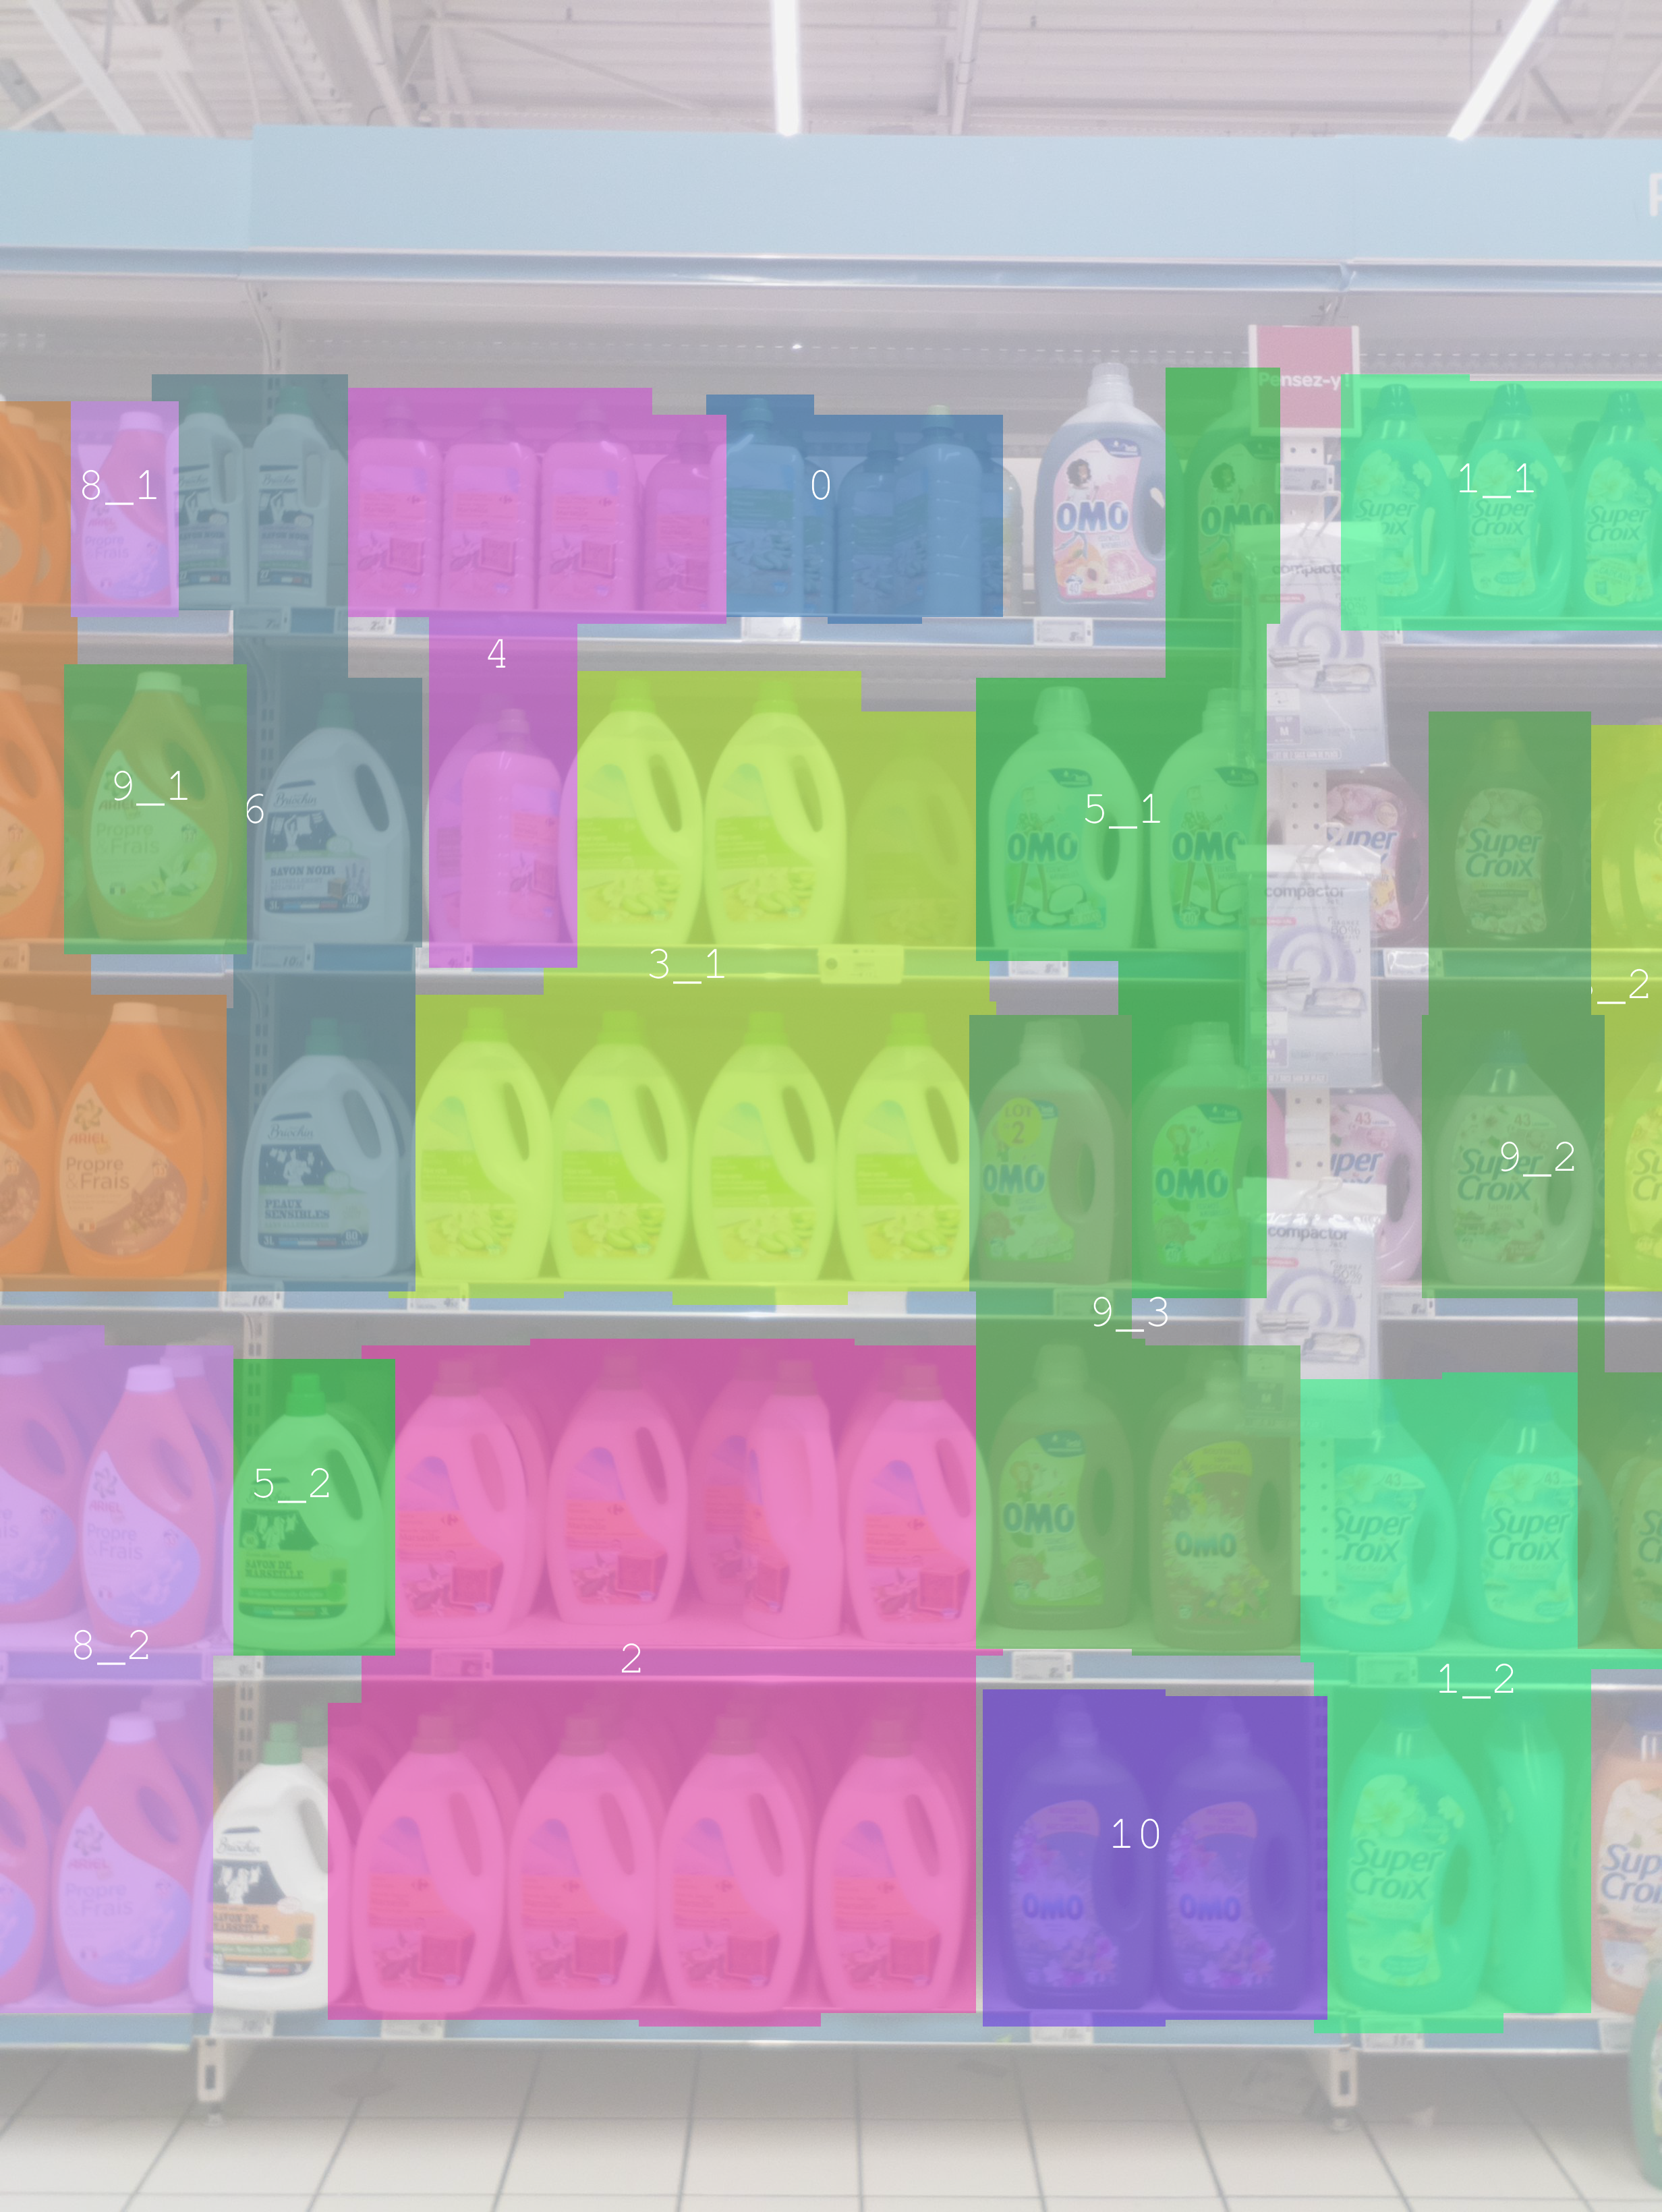

In [11]:
from PIL import ImageDraw, ImageFont
from skimage.morphology import closing, square
from skimage.transform import rescale, resize
from skimage import measure

def aggregation(im: Image, bbs, clusters):
    im_rgba = im.copy().convert('RGBA')
    im_rgba.putalpha(128)

    overlay = Image.new('RGBA', im.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)  # draw overlay

    num_clusters = len(np.unique(clusters)) - 1
    colors = list(np.random.choice(range(256), size=(num_clusters, 3)))

    font_size = 70
    font = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", size=font_size)
    for i in range(num_clusters):
        mask = np.zeros((im.size[1], im.size[0]))

        flag = clusters == i
        bbs_i = np.array(bbs)[flag, :]
        for bb_i in bbs_i:
            mask[bb_i[1]:bb_i[3] + 1, bb_i[0]:bb_i[2] + 1] = 1

        mask_rescaled = rescale(mask, 0.1, anti_aliasing=False)
        mask_rescaled = closing(mask_rescaled, square(15))
        mask = (resize(mask_rescaled, (im.size[1], im.size[0]), anti_aliasing=False) > 0).astype(np.uint8)

        im_mask = Image.fromarray(mask * 255, mode='L')
        # im_mask.show()
        draw.bitmap((0, 0), im_mask, fill=(tuple(colors[i]) + (128,)))

        # connected components
        labeled = measure.label(mask == 1, background=0)
        n_cc = np.max(labeled)
        for n in np.arange(n_cc) + 1:
            indices = np.where(labeled == n)
            position = (np.round((np.min(indices[1]) + np.max(indices[1])) / 2.0).astype(int) - font_size,
                        np.round((np.min(indices[0]) + np.max(indices[0])) / 2.0).astype(int) - font_size)

            if n_cc > 1:
                draw.text(position, str(i) + '_' + str(n), font=font, align='center')
            else:
                draw.text(position, str(i), font=font, align='center')

    im_a = Image.alpha_composite(im_rgba, overlay)
    display(im_a)
    
aggregation(im, bbs, clusters)